In [163]:
import numpy as np
np.set_printoptions(precision=4)  # Print few decimal places
np.set_printoptions(suppress=True)  # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt

In [52]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [183]:
X_train, y_train = load_mnist('raw_data', kind='train')
X_test, y_test = load_mnist('raw_data', kind='t10k')
m, n = X_train.shape
print("m: ", m, "n:", n)

m:  60000 n: 784


([], [])

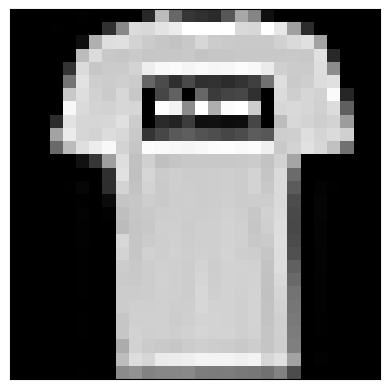

In [54]:
# Example image visualization
x_viz = X_train[1].reshape(-1, 28)
plt.imshow(x_viz, cmap='gray')
plt.xticks([])
plt.yticks([])

In [55]:
# Reduce dataset size to keep solver reasonable (not used)
# import numpy as np
def create_balanced_subsample(X, y, samples_per_class):
    """
    Create a balanced subsample of data with equal representation of each class.
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        The input data
    y : array-like of shape (n_samples,)
        The target labels
    samples_per_class : int
        Number of samples to include per class
        
    Returns:
    --------
    X_subsample : array-like
        Subsampled feature data
    y_subsample : array-like
        Corresponding labels
    """
    classes = np.unique(y)
    indices = []
    
    for c in classes:
        # Find indices of samples belonging to this class
        class_indices = np.where(y == c)[0]
        
        # If we have fewer samples than requested, take all of them
        if len(class_indices) <= samples_per_class:
            indices.append(class_indices)
        else:
            # Otherwise randomly select the requested number
            selected = np.random.choice(class_indices, size=samples_per_class, replace=False)
            indices.append(selected)
    
    # Combine all selected indices and shuffle them
    combined_indices = np.concatenate(indices)
    np.random.shuffle(combined_indices)
    
    return X[combined_indices], y[combined_indices]

# Determine how many samples to include per class
# For example, 500 samples per class for training, 100 for testing
train_samples_per_class = 500  # Adjust as needed
test_samples_per_class = 100   # Adjust as needed

# Create balanced subsamples
X_train_balanced, y_train_balanced = create_balanced_subsample(X_train, y_train, train_samples_per_class)
X_test_balanced, y_test_balanced = create_balanced_subsample(X_test, y_test, test_samples_per_class)

# Print information about the subsampled datasets
print(f"Original training set: {X_train.shape[0]} samples")
print(f"Balanced training subsample: {X_train_balanced.shape[0]} samples ({train_samples_per_class} per class)")
print(f"Original test set: {X_test.shape[0]} samples")
print(f"Balanced test subsample: {X_test_balanced.shape[0]} samples ({test_samples_per_class} per class)")

# Verify class distribution in the subsample
unique, counts = np.unique(y_train_balanced, return_counts=True)
print("\nClass distribution in training subsample:")
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} samples")

Original training set: 60000 samples
Balanced training subsample: 5000 samples (500 per class)
Original test set: 10000 samples
Balanced test subsample: 1000 samples (100 per class)

Class distribution in training subsample:
Class 0: 500 samples
Class 1: 500 samples
Class 2: 500 samples
Class 3: 500 samples
Class 4: 500 samples
Class 5: 500 samples
Class 6: 500 samples
Class 7: 500 samples
Class 8: 500 samples
Class 9: 500 samples


In [184]:
def create_balanced_binary_dataset(X, y, shirt_class=6, n_samples_per_category=1000):
    """
    Create a balanced binary dataset with equal representation of shirts and non-shirts.
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        The input data
    y : array-like of shape (n_samples,)
        The target labels
    shirt_class : int, default=6
        The class label for shirts in the dataset
    n_samples_per_category : int, default=1000
        Number of samples to include for each category (shirt/non-shirt)
        
    Returns:
    --------
    X_binary : array-like
        Subsampled feature data
    y_binary : array-like
        Binary labels (1 for shirt, -1 for non-shirt)
    """
    # Find shirt indices
    shirt_indices = np.where(y == shirt_class)[0]
    
    # Find non-shirt indices (all other classes)
    nonshirt_indices = np.where(y != shirt_class)[0]
    
    # Sample from each category
    if len(shirt_indices) <= n_samples_per_category:
        selected_shirt_indices = shirt_indices
    else:
        selected_shirt_indices = np.random.choice(
            shirt_indices, size=n_samples_per_category, replace=False)
    
    if len(nonshirt_indices) <= n_samples_per_category:
        selected_nonshirt_indices = nonshirt_indices
    else:
        selected_nonshirt_indices = np.random.choice(
            nonshirt_indices, size=n_samples_per_category, replace=False)
    
    # Combine indices
    selected_indices = np.concatenate([selected_shirt_indices, selected_nonshirt_indices])
    
    # Create binary features and labels
    X_binary = X[selected_indices]
    
    # Create binary labels: 1 for shirts, -1 for non-shirts
    y_binary = np.ones(len(selected_indices))
    y_binary[n_samples_per_category:] = -1  # The second half are non-shirts
    
    # Shuffle the data
    shuffle_idx = np.random.permutation(len(y_binary))
    X_binary = X_binary[shuffle_idx]
    y_binary = y_binary[shuffle_idx]
    
    return X_binary, y_binary


X_train_bin, y_train_bin = create_balanced_binary_dataset(X_train, y_train, shirt_class=6, n_samples_per_category=2500)
X_test_bin, y_test_bin = create_balanced_binary_dataset(X_test, y_test, shirt_class=6, n_samples_per_category=500)

In [185]:
pd.DataFrame(X_train_bin).to_csv("data/X_train.csv", index=False)
pd.DataFrame(X_test_bin).to_csv("data/X_test.csv", index=False)
pd.DataFrame(y_train_bin, columns=['label']).to_csv("data/y_train.csv", index=False)
pd.DataFrame(y_test_bin, columns=['label']).to_csv("data/y_test.csv", index=False)

In [198]:
# 1. Write classification problem using linear programming
lam = cp.Parameter(nonneg=True)
a = cp.Variable(n)
b = cp.Variable()
loss = cp.sum(cp.pos(1 - cp.multiply(y_train_bin, X_train_bin @ a + b)))/len(y_train_bin)
regularization  = cp.norm(a,1)
problem = cp.Problem(cp.Minimize(loss + lam * regularization))

lam.value = 0.01
problem.solve(solver=cp.CLARABEL)

np.float64(0.23904390710525703)

In [199]:
y_train_pred  = np.sign(X_train_bin @ a.value + b.value)
y_test_pred   = np.sign(X_test_bin @ a.value + b.value)
train_error = (y_train_bin != y_train_pred).sum()/len(y_train_bin)
test_error  = (y_test_bin != y_test_pred).sum()/len(y_test_bin)    
print(f"{'='*50}")
print(f"LINEAR SVM WITH L1 REGULARIZATION RESULTS")
print(f"{'='*50}")
print(f"Target class: Shirt (class {shirt})")
print(f"Regularization parameter (lambda): {lam.value}")
print(f"Optimization problem status: {problem.status}")
print(f"Objective value: {problem.value:.6f}")
print(f"\nPERFORMANCE METRICS:")
print(f"{'-'*50}")
print(f"Training error rate: {train_error:.4f} ({(train_error*100):.2f}%)")
print(f"Test error rate:     {test_error:.4f} ({(test_error*100):.2f}%)")
print(f"\nMODEL SPARSITY:")
print(f"{'-'*50}")
print(f"Number of non-zero coefficients: {np.sum(np.abs(a.value) > 1e-6)}/{n}")
print(f"Percentage of non-zero coefficients: {(np.sum(np.abs(a.value) > 1e-6)/n)*100:.2f}%")
print(f"Intercept (b): {b.value:.6f}")
print(f"{'='*50}")

LINEAR SVM WITH L1 REGULARIZATION RESULTS
Target class: Shirt (class 6)
Regularization parameter (lambda): 0.01
Optimization problem status: optimal
Objective value: 0.239044

PERFORMANCE METRICS:
--------------------------------------------------
Training error rate: 0.0814 (8.14%)
Test error rate:     0.1800 (18.00%)

MODEL SPARSITY:
--------------------------------------------------
Number of non-zero coefficients: 681/784
Percentage of non-zero coefficients: 86.86%
Intercept (b): 0.792426


In [141]:
## Create outliers
def add_outliers(X_train, s_train, outlier_percentage=0.05, outlier_magnitude=10.0):
    """
    Add outliers to the training data by:
    1. Randomly selecting a subset of training examples
    2. Modifying their feature values to be abnormally large/small
    3. Flipping their labels
    
    Parameters:
    -----------
    X_train : array-like, shape (n_samples, n_features)
        Training feature data
    s_train : array-like, shape (n_samples,)
        Training labels (-1, +1)
    outlier_percentage : float, default=0.05
        Percentage of training examples to convert to outliers
    outlier_magnitude : float, default=10.0
        Factor by which to scale the outlier features
        
    Returns:
    --------
    X_train_with_outliers : array-like, shape (n_samples, n_features)
        Training data with outliers added
    s_train_with_outliers : array-like, shape (n_samples,)
        Training labels with outliers (some labels flipped)
    outlier_indices : array-like
        Indices of the rows that were converted to outliers
    """
    # Create copies and ensure we're working with float data type to allow negative values
    X_train_with_outliers = X_train.copy().astype(float)
    s_train_with_outliers = s_train.copy()
    
    n_samples = X_train.shape[0]
    n_outliers = int(outlier_percentage * n_samples)
    
    # Randomly select indices to become outliers
    outlier_indices = np.random.choice(n_samples, size=n_outliers, replace=False)
    
    # Add outliers using different strategies
    for idx in outlier_indices:
        # Strategy 1: Flip the label
        s_train_with_outliers[idx] *= -1
        
        # Strategy 2: Apply one of several feature perturbations
        perturbation_type = np.random.randint(0, 4)
        
        if perturbation_type == 0:
            # Scale features by a large factor
            X_train_with_outliers[idx] *= outlier_magnitude
        elif perturbation_type == 1:
            # Replace with random extreme values
            X_train_with_outliers[idx] = np.random.uniform(
                0, 255, size=X_train.shape[1])  # Stay within valid image range
        elif perturbation_type == 2:
            # Set values to be unusually high but valid for images
            X_train_with_outliers[idx] = np.minimum(X_train_with_outliers[idx] + 200, 255)
        else:
            # Use a completely unrelated image pattern
            # Create a checkerboard pattern with valid pixel values
            pattern = np.zeros_like(X_train_with_outliers[idx])
            pattern[::2] = 255  # White
            pattern[1::2] = 0   # Black
            X_train_with_outliers[idx] = pattern
    
    return X_train_with_outliers, s_train_with_outliers, outlier_indices

# Example usage:
outlier_percentage = 0.05  # 5% outliers
outlier_magnitude = 10.0   # Scale factor for outlier features

# Generate training data with outliers
X_train_outliers, s_train_outliers, outlier_indices = add_outliers(
    X_train, s_train, outlier_percentage, outlier_magnitude)

# Print information about the outliers
print(f"Added {len(outlier_indices)} outliers ({outlier_percentage*100:.1f}% of data)")

Added 250 outliers (5.0% of data)


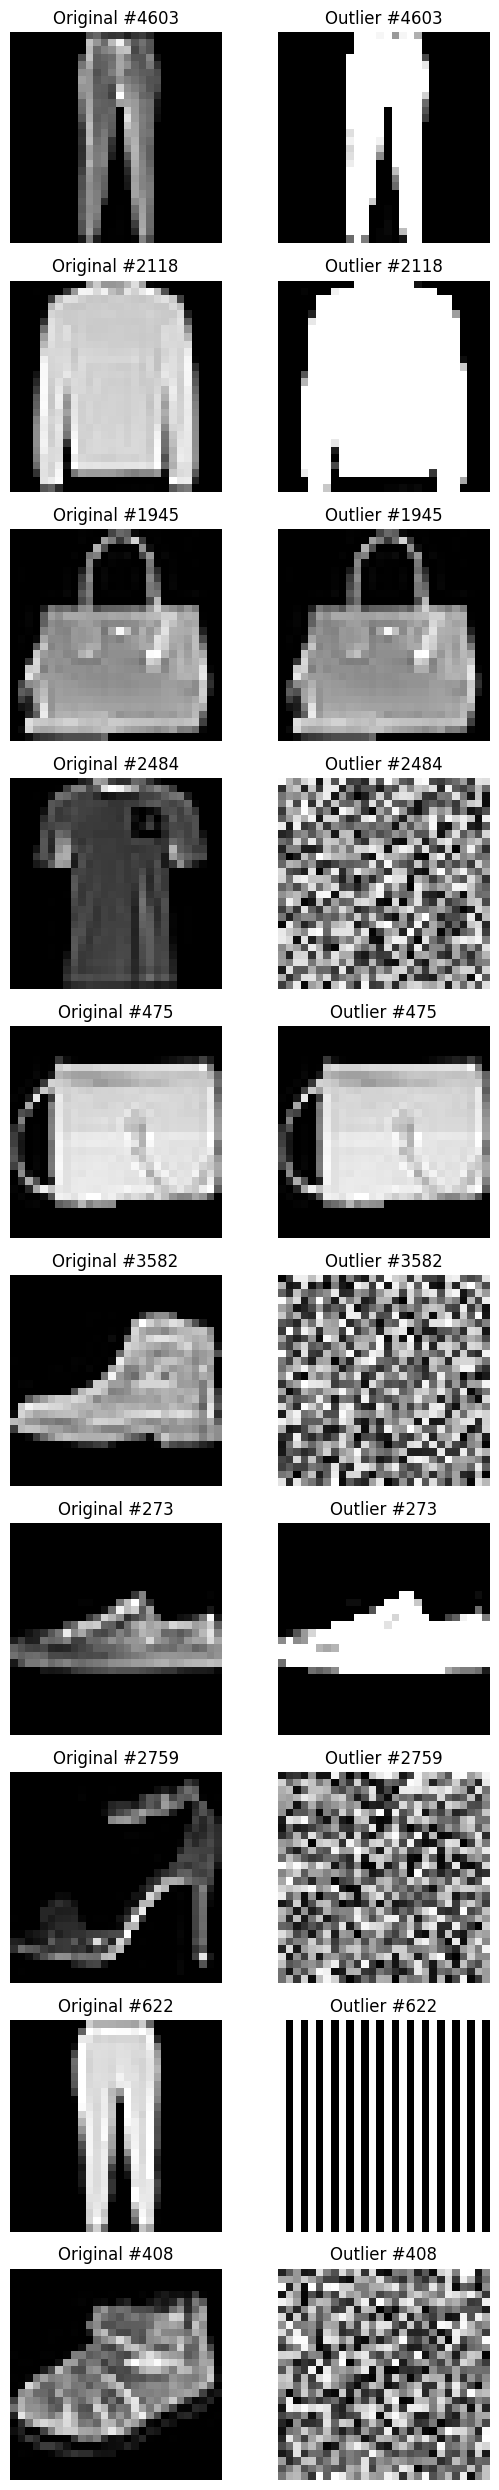

In [142]:
# Visualize some outliers (assuming images are 28x28)
def plot_outlier_examples(X_orig, X_outliers, outlier_indices, n_examples=10):
    """Plot original vs. outlier examples"""
    fig, axes = plt.subplots(n_examples, 2, figsize=(6, 2.5*n_examples))
    
    # Randomly select n_examples from the outlier indices
    selected_indices = np.random.choice(outlier_indices, size=min(n_examples, len(outlier_indices)), replace=False)
    
    for i, idx in enumerate(selected_indices):
        # Plot original image
        axes[i, 0].imshow(X_orig[idx].reshape(28, 28), cmap='gray')
        axes[i, 0].set_title(f"Original #{idx}")
        axes[i, 0].axis('off')
        
        # Plot outlier version
        axes[i, 1].imshow(X_outliers[idx].reshape(28, 28), cmap='gray')
        axes[i, 1].set_title(f"Outlier #{idx}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize examples
plot_outlier_examples(X_train, X_train_outliers, outlier_indices)

In [167]:
# Now run the original optimization problem with outliers
# ...use X_train_outliers and s_train_outliers in your optimization code...

# Comparative analysis function
def compare_models(X_train, s_train, X_train_outliers, s_train_outliers, X_test, s_test, regularization_values):
    """Compare model performance with and without outliers across different regularization strengths"""
    results = []
    
    for lam_value in regularization_values:
        # Model without outliers
        lam.value = lam_value
        a_clean = cp.Variable(n)
        b_clean = cp.Variable()
        loss_clean = cp.sum(cp.pos(1 - cp.multiply(s_train, X_train @ a_clean + b_clean)))/len(s_train)
        reg_clean = cp.norm(a_clean, 1)
        prob_clean = cp.Problem(cp.Minimize(loss_clean + lam * reg_clean))
        prob_clean.solve(solver=cp.CLARABEL)
        
        # Test performance with clean model
        s_test_pred_clean = np.sign(X_test @ a_clean.value + b_clean.value)
        test_error_clean = np.mean(s_test != s_test_pred_clean)
        
        # Model with outliers
        a_outlier = cp.Variable(n)
        b_outlier = cp.Variable()
        loss_outlier = cp.sum(cp.pos(1 - cp.multiply(s_train_outliers, X_train_outliers @ a_outlier + b_outlier)))/len(s_train_outliers)
        reg_outlier = cp.norm(a_outlier, 1)
        prob_outlier = cp.Problem(cp.Minimize(loss_outlier + lam * reg_outlier))
        prob_outlier.solve(solver=cp.CLARABEL)
        
        # Test performance with outlier model
        s_test_pred_outlier = np.sign(X_test @ a_outlier.value + b_outlier.value)
        test_error_outlier = np.mean(s_test != s_test_pred_outlier)
        
        # Store results
        results.append({
            'lambda': lam_value,
            'test_error_clean': test_error_clean,
            'test_error_with_outliers': test_error_outlier,
            'error_difference': test_error_outlier - test_error_clean,
            'sparsity_clean': np.sum(np.abs(a_clean.value) > 1e-6),
            'sparsity_with_outliers': np.sum(np.abs(a_outlier.value) > 1e-6)
        })
    
    return results

# Compare model performance across regularization strengths
lambdas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1.0]
comparison = compare_models(X_train, s_train, X_train_outliers, s_train_outliers, 
                           X_test, s_test, lambdas)

# Display comparison results
import pandas as pd
pd.DataFrame(comparison).set_index('lambda').round(4)

,test_error_clean,test_error_with_outliers,error_difference,sparsity_clean,sparsity_with_outliers
lambda,,,,,
0.0001,0.142,0.142,0.000,757,777
0.0005,0.141,0.143,0.002,737,766
0.0010,0.134,0.146,0.012,719,759
0.0050,0.128,0.123,-0.005,659,714
0.0100,0.115,0.115,0.000,603,656
0.1000,0.097,0.093,-0.004,309,372
1.0000,0.100,0.101,0.001,0,85


It seems that the model is pretty robust to outliers! 

In [143]:
a = cp.Variable(n)
b = cp.Variable()

## Primal problem with norms
lam = cp.Parameter(nonneg=True)
loss = cp.sum(cp.pos(1 - cp.multiply(s_train, X_train @ a + b)))/len(s_train)
regularization  = cp.norm(a,1)
problem = cp.Problem(cp.Minimize(loss + lam * regularization))

lam.value = 0.1
problem.solve(solver=cp.CLARABEL, verbose=False)
a_auto, b_auto = a.value, b.value
auto_value = problem.value

In [144]:
## Primal reformulation inequality form
n_train = X_train.shape[0]
u = cp.Variable(n_train)
r = cp.Variable(n)
objective = 1/n_train * cp.sum(u) + lam * cp.sum(r)
constraints = [1 - cp.multiply(s_train, X_train @ a + b) <= u,  # remember to normalize error
               0 <= u,
               a <= r, 
               -a <= r]
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve(solver=cp.CLARABEL, verbose=False)
a_lp, b_lp = a.value, b.value
lp_value = problem.value
duals_lp = constraints[0].dual_value

In [145]:
## Dual reformulation
y = cp.Variable(n_train)
z = cp.Variable(n)
q = cp.Variable(n)

objective = cp.sum(y)
constraints = [y <= np.ones(n_train)/n_train,
               lam * np.ones(n) == z + q,
               X_train.T @ cp.multiply(s_train, y) == z - q,
               s_train @ y == 0,
               y >= 0, z >= 0, q >= 0]
problem = cp.Problem(cp.Maximize(objective), constraints)
problem.solve(solver=cp.CLARABEL, verbose=False)
duals_dual = y.value
dual_value = problem.value

In [146]:
print("primal obj: ", lp_value)
print("dual obj: ", dual_value)

primal obj:  0.16467724967146102
dual obj:  0.16467733009732


Maximum dual value: 0.000200
Number of support vectors with maximum dual value: 691


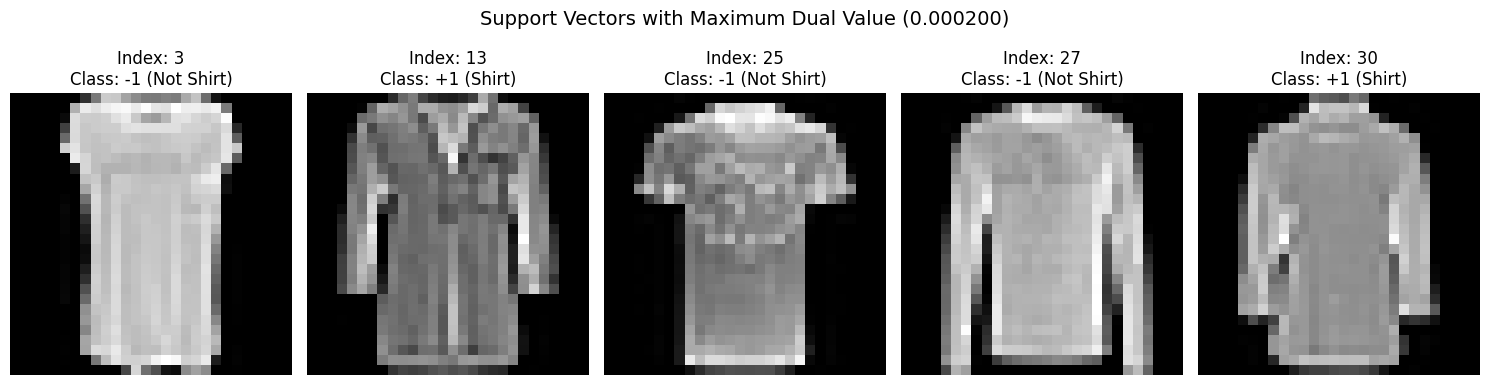


Class distribution of maximum dual vectors:
Positive class (Shirt): 398
Negative class (Not Shirt): 293


In [147]:
## look at active constraints
idx_active = duals_dual > 1e-04

# Check if we found any active constraints
if not np.any(idx_active):
    print("No active constraints found!")
else:
    # Find the maximum dual value
    max_dual_value = np.max(duals_dual[idx_active])
    
    # Find indices where dual values are at or near the maximum
    # Using a small tolerance to catch numerically close values
    tolerance = 1e-6
    max_dual_indices = np.where(np.abs(duals_dual - max_dual_value) < tolerance)[0]
    
    # Print information about max dual values
    print(f"Maximum dual value: {max_dual_value:.6f}")
    print(f"Number of support vectors with maximum dual value: {len(max_dual_indices)}")
    
    # Display the support vectors with maximum dual value
    num_to_display = min(5, len(max_dual_indices))
    
    plt.figure(figsize=(15, 4))
    plt.suptitle(f"Support Vectors with Maximum Dual Value ({max_dual_value:.6f})", fontsize=14)
    
    for i in range(num_to_display):
        idx = max_dual_indices[i]
        plt.subplot(1, num_to_display, i + 1)
        plt.imshow(X_train[idx].reshape(28, 28), cmap='gray')
        label_text = '+1 (Shirt)' if s_train[idx] == 1 else '-1 (Not Shirt)'
        plt.title(f"Index: {idx}\nClass: {label_text}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    plt.show()
    
    # Check class distribution of max dual vectors
    num_pos_class = np.sum(s_train[max_dual_indices] == 1)
    num_neg_class = np.sum(s_train[max_dual_indices] == -1)
    
    print(f"\nClass distribution of maximum dual vectors:")
    print(f"Positive class (Shirt): {num_pos_class}")
    print(f"Negative class (Not Shirt): {num_neg_class}")

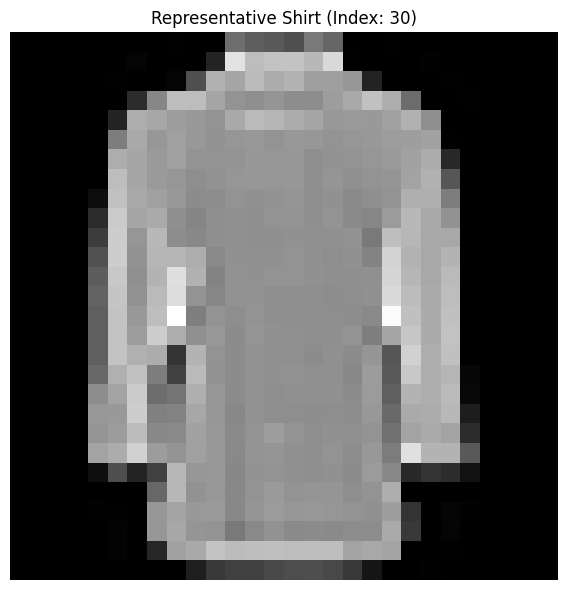


Formal Verification Results:
Found an adversarial example at distance: 147.7325


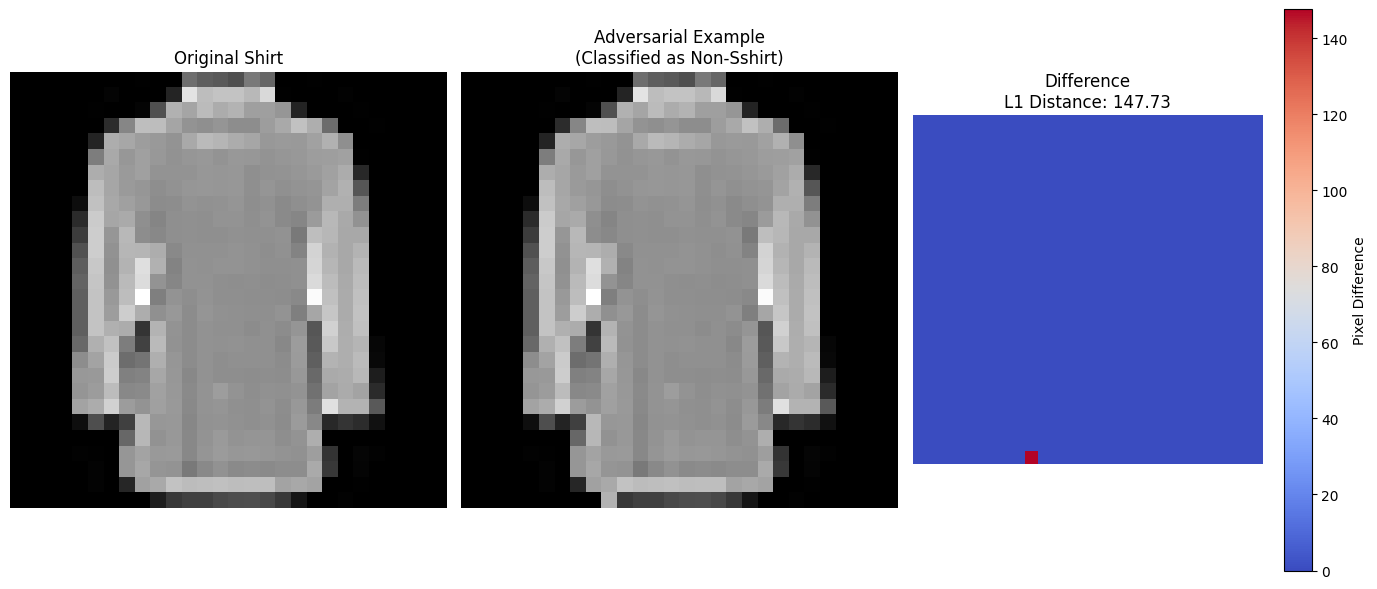

In [162]:
# Formulate adversarial example problem

# Step 1: Select a representative shirt image
# Find a shirt example that is correctly classified and not on the boundary
shirt_class = 6  # Assuming 6 is the t-shirt class in Fashion MNIST
correct_shirts = np.where((y_train == shirt_class) & 
                           (s_train == 1) & 
                           (s_train == np.sign(X_train @ a.value + b.value)) &
                           (duals_dual < max_dual_value))[0]

# Choose the first suitable shirt example
center_idx = correct_shirts[0]
center_image = X_train[center_idx]

# Step 2: Display the selected center image
plt.figure(figsize=(6, 6))
plt.imshow(center_image.reshape(28, 28), cmap='gray')
plt.title(f"Representative Shirt (Index: {center_idx})")
plt.axis('off')
plt.tight_layout()
plt.show()

# Define a verification problem: find the closest point to the center that gets misclassified
radius = 50.0

# For a shirt center, find the closest point classified as NOT a shirt
adversarial_x = cp.Variable(len(center_image))
objective = cp.Minimize(cp.norm(adversarial_x - center_image, 1))

# The point should be misclassified (for a shirt center, the point should be classified as non-shirt)
# That means a^T x + b ≤ 0
# The pixels should be within givenbounds
constraints = [adversarial_x @ a.value + b.value <= -1e-03,
               adversarial_x <= 255, 0 <= adversarial_x]

# Solve the verification problem
verification_problem = cp.Problem(objective, constraints)
verification_result = verification_problem.solve(solver=cp.CLARABEL)

if verification_problem.status in ['optimal', 'optimal_inaccurate']:
    # Found a misclassified point
    adversarial_example = adversarial_x.value
    adversarial_distance = np.linalg.norm(adversarial_example - center_image, 1)
    
    print("\nFormal Verification Results:")
    print(f"Found an adversarial example at distance: {adversarial_distance:.4f}")
    
    # Visualize the adversarial example
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(center_image.reshape(28, 28), cmap='gray')
    plt.title("Original Shirt")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(adversarial_example.reshape(28, 28), cmap='gray')
    plt.title("Adversarial Example\n(Classified as Non-Shirt)")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow((adversarial_example - center_image).reshape(28, 28), cmap='coolwarm')
    plt.title(f"Difference\nL1 Distance: {adversarial_distance:.2f}")
    plt.colorbar(label='Pixel Difference')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [157]:
X_train[0].shape

(784,)

In [158]:
np.sqrt(X_train[0].shape[0])


np.float64(28.0)

In [160]:
X_train.shape

(5000, 784)

In [161]:
X_test.shape

(1000, 784)

In [200]:
# Defective probabilities

# Pick only shirts
shirt_indices = np.where(y_train == shirt)[0]
X_shirt = X_train[shirt_indices]


def sigmoid(x):
    return 1 / (1 + np.exp(-x))
p_train = sigmoid(-(X_shirt @ a.value + b.value))

(array([2345., 1237., 1075.,  389.,  285.,  195.,  139.,  113.,  107.,
         115.]),
 array([0.    , 0.1   , 0.2   , 0.3   , 0.3999, 0.4999, 0.5999, 0.6999,
        0.7998, 0.8998, 0.9998]),
 <BarContainer object of 10 artists>)

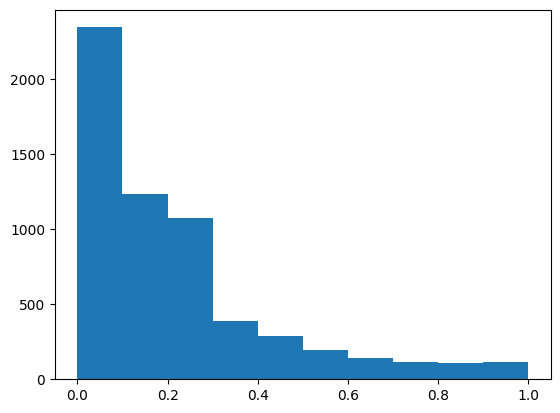

In [201]:
plt.hist(p_train)